In [1]:
!pip install -q transformers datasets "torch>=1.10" scikit-learn

In [2]:
from transformers import pipeline
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import time

In [3]:
model_name = "facebook/bart-large-mnli"
classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    device= 0
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [4]:
# Load dataset
dataset = load_dataset("yahoo_answers_topics")
print(dataset)

# Sample size (50–200)
SAMPLE_SIZE = 200
random_seed = 42
rng = random.Random(random_seed)

# Extract samples
test_data = dataset["test"]
indices = rng.sample(range(len(test_data)), SAMPLE_SIZE)
samples = [test_data[i] for i in indices]

# Yahoo dataset structure
# features: question_title, question_content, best_answer, topic
def example_text(row):
    return row["question_title"] + " " + row["question_content"]

texts = [example_text(s) for s in samples]
true_labels_idx = [s["topic"] for s in samples]

README.md: 0.00B [00:00, ?B/s]

yahoo_answers_topics/train-00000-of-0000(…):   0%|          | 0.00/241M [00:00<?, ?B/s]

yahoo_answers_topics/train-00001-of-0000(…):   0%|          | 0.00/270M [00:00<?, ?B/s]

yahoo_answers_topics/test-00000-of-00001(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})


In [17]:
label_map = {
    0: "society & culture",
    1: "science & mathematics",
    2: "health",
    3: "education & reference",
    4: "computers & internet",
    5: "sports",
    6: "business & finance",
    7: "entertainment & music",
    8: "family & relationships",
    9: "politics & government"
}

true_labels = [label_map[i] for i in true_labels_idx]
candidate_labels = list(label_map.values())
label_names = candidate_labels

In [8]:
preds = []
scores = []

start = time.time()
for text in texts:
    out = classifier(text, candidate_labels, multi_label=False)
    preds.append(out["labels"][0])
    scores.append(out["scores"][0])
end = time.time()

print(f"Finished classifying {SAMPLE_SIZE} samples in {end-start:.2f}s")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Finished classifying 200 samples in 70.75s


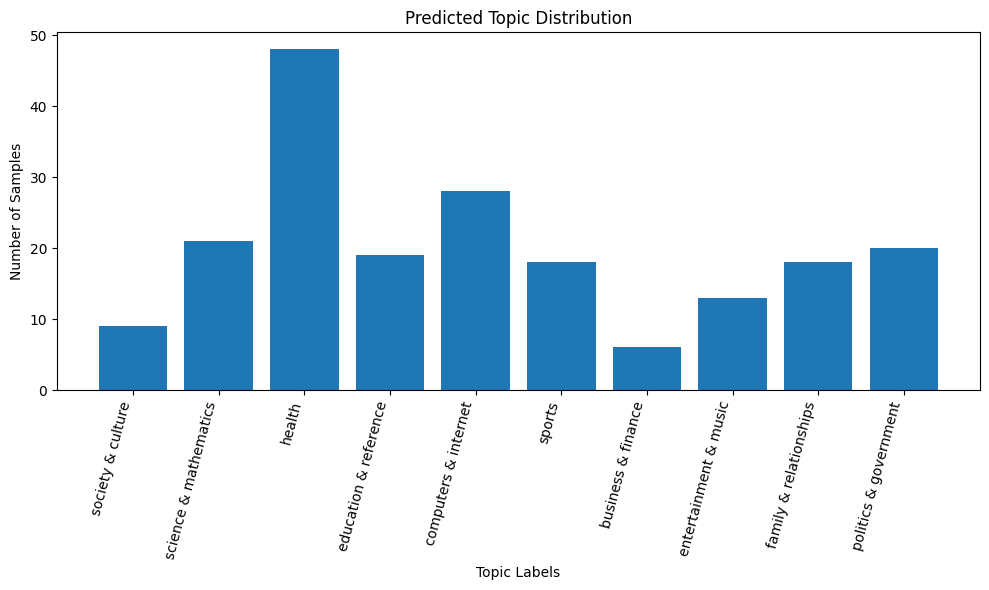

In [20]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(label_names, counts)
plt.xticks(rotation=75, ha="right")
plt.title("Predicted Topic Distribution")
plt.xlabel("Topic Labels")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

In [9]:
print("Accuracy:", accuracy_score(true_labels, preds))
print("\nClassification Report:")
print(classification_report(true_labels, preds, digits=4))

Accuracy: 0.565

Classification Report:
                        precision    recall  f1-score   support

    business & finance     0.5556    0.2500    0.3448        20
  computers & internet     0.7143    0.5769    0.6383        26
 education & reference     0.2292    0.5789    0.3284        19
 entertainment & music     0.6316    0.6000    0.6154        20
family & relationships     0.5357    0.8333    0.6522        18
                health     0.8333    0.7895    0.8108        19
 politics & government     0.8333    0.2778    0.4167        18
 science & mathematics     0.7692    0.5000    0.6061        20
     society & culture     0.3333    0.3529    0.3429        17
                sports     0.9500    0.8261    0.8837        23

              accuracy                         0.5650       200
             macro avg     0.6386    0.5585    0.5639       200
          weighted avg     0.6502    0.5650    0.5748       200



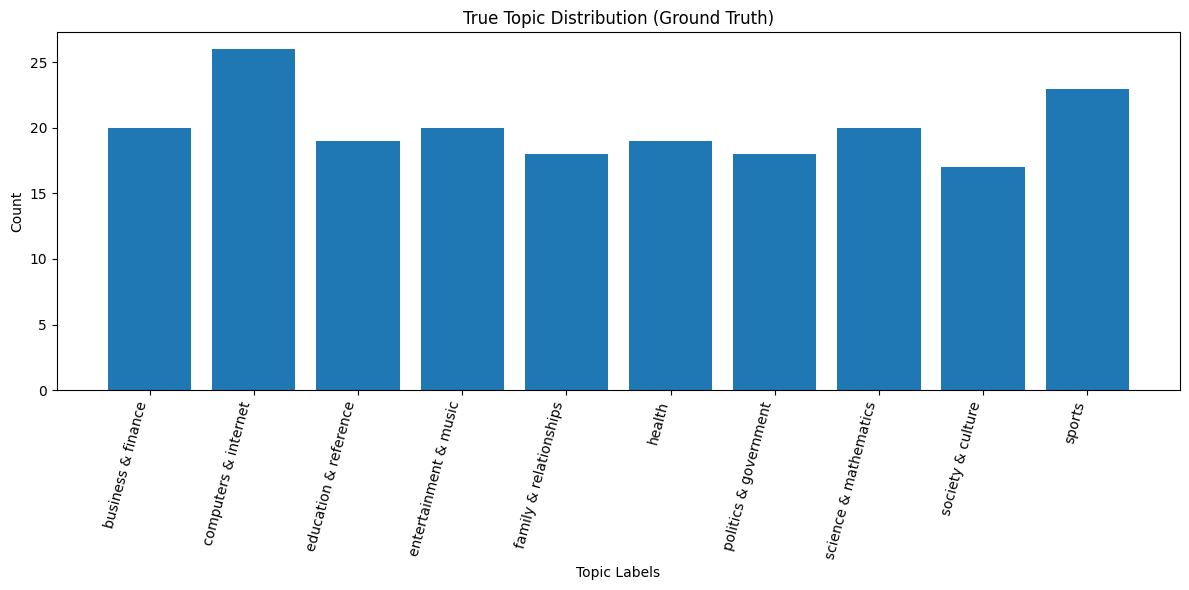

In [19]:
true_unique, true_counts = np.unique(true_labels, return_counts=True)

plt.figure(figsize=(12,6))
plt.bar(true_unique, true_counts)
plt.xticks(rotation=75, ha="right")
plt.title("True Topic Distribution (Ground Truth)")
plt.xlabel("Topic Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [10]:
df = pd.DataFrame({
    "text": [t[:200] + ("..." if len(t)>200 else "") for t in texts],
    "true_label": true_labels,
    "pred_label": preds,
    "confidence": scores
})
df.head(10)

,text,true_label,pred_label,confidence
0,What exercise?? To get into using a compound b...,sports,education & reference,0.284675
1,"For thoes of you that don't smoke marijuana, w...",society & culture,education & reference,0.298406
2,"girls fight over me all the time,and i always ...",family & relationships,family & relationships,0.620628
3,what is internet? abcd,computers & internet,computers & internet,0.248497
4,Why is gym a must class in high school to be a...,education & reference,education & reference,0.367245
5,What's the fastest way to lose weight? Im goin...,health,sports,0.276052
6,is their anyway to inc rise the height ? i am ...,health,health,0.363925
7,what is the only different between the two leg...,family & relationships,family & relationships,0.177835
8,Why only one side of the Moon is seen? Please ...,science & mathematics,science & mathematics,0.671283
9,which is the best book to learn vc++.net?,computers & internet,education & reference,0.419560


In [11]:
cm = confusion_matrix(true_labels, preds, labels=candidate_labels)
cm_df = pd.DataFrame(cm, index=candidate_labels, columns=candidate_labels)
cm_df

,society & culture,science & mathematics,health,education & reference,computers & internet,sports,business & finance,entertainment & music,family & relationships,politics & government
society & culture,6,0,0,7,0,0,0,2,2,0
science & mathematics,2,10,1,7,0,0,0,0,0,0
health,0,0,15,3,0,1,0,0,0,0
education & reference,4,2,0,11,0,0,1,0,1,0
computers & internet,1,0,1,5,15,0,0,3,1,0
sports,0,0,0,1,0,19,0,2,0,1
business & finance,2,1,0,6,3,0,5,0,3,0
entertainment & music,1,0,0,2,1,0,0,12,4,0
family & relationships,1,0,1,0,1,0,0,0,15,0
politics & government,1,0,0,6,1,0,3,0,2,5


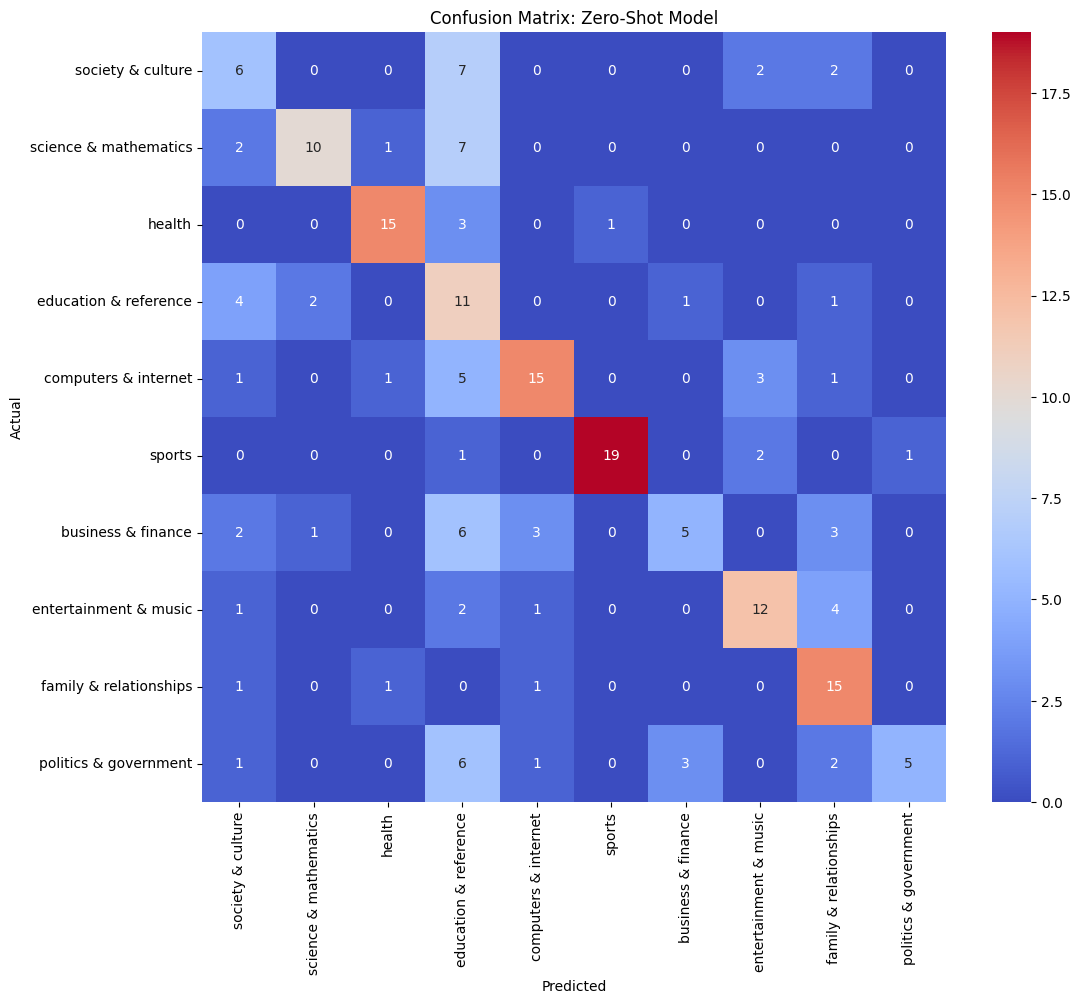

In [24]:
cm = confusion_matrix(true_labels, preds, labels=candidate_labels)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix: Zero-Shot Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
results_df = pd.DataFrame({
    "text": texts,
    "true_label": true_labels,
    "pred_label": preds,
    "confidence": scores
})

results_df.to_csv("zero_shot_yahoo_results.csv", index=False)
print("Saved as zero_shot_yahoo_results.csv")

Saved as zero_shot_yahoo_results.csv
